# importing libraries

In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score , precision_score , recall_score , roc_auc_score , confusion_matrix , f1_score
from sklearn.svm import SVC ,LinearSVC
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from yellowbrick.target import FeatureCorrelation
from sklearn.metrics import ConfusionMatrixDisplay

# Functions

this will classify No2 between labels

In [163]:
def set_tags_no2(labels):
  templ=np.array(labels,dtype='object')
  for i in range(len(labels)):
    if labels[i]>100:
      templ[i]='Very unhealthy'
    elif labels[i]<=100 and labels[i]>80:
      templ[i]='Unhealthy'
    elif labels[i]<=80 and labels[i]>40:
      templ[i]='Unhealthy for sensitive group'
    elif labels[i]<=40 and labels[i]>20:
      templ[i]='Moderate'
    else:
      templ[i]='Good'
  return templ

In [164]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [165]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [166]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

features importance

In [167]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score

In [168]:
def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

In [169]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

In [170]:
def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(10,20))

    indices = perm_importance_result['importances_mean'].argsort()
    y=perm_importance_result['importances_mean'][indices]
    plt.barh(range(len(indices)),
             y,
             xerr=perm_importance_result['importances_std'][indices],color='blue')

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    for i, v in enumerate(y):
      ax.text(0, i, str(round(v, 2)), color='black', fontweight='bold')

pearson correlation function

In [171]:
def correlation(ino,oto):
  X, y = ino, oto

  # Create a list of the feature names
  features = np.array(X.columns.tolist())

  # Instantiate the visualizer
  visualizer = FeatureCorrelation(labels=features)

  visualizer.fit(X, y)        # Fit the data to the visualizer
  visualizer.show()    

confusion matrix plot

In [172]:
def confplt(classifier,X_test,y_test,class_names):
  titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)


# data processing for differant machines

adding new columns as desired

In [173]:
DF2018=pd.read_csv('mix2018.csv')
# print(DF2018.head())
DF2019=pd.read_csv('mix2019.csv')
# print(DF2019.head())
DF2018.reset_index(drop=True, inplace=True)
DF2019.reset_index(drop=True, inplace=True)

tf=DF2018['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF2018['two_wheeled_motor_vehicles']=twmv
DF2018['cars_and_taxis']=cat
DF2018['buses_and_coaches']=bac
DF2018['lgvs']=lgvs


tf=DF2019['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF2019['two_wheeled_motor_vehicles']=twmv
DF2019['cars_and_taxis']=cat
DF2019['buses_and_coaches']=bac
DF2019['lgvs']=lgvs
DF2018=DF2018.drop('Traffic Flow',axis=1)
DF2018=DF2018.drop('Congestion',axis=1)

DF2019=DF2019.drop('Congestion',axis=1)
print(DF2018.columns,"\n\n\n\n",DF2019.columns)

Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Solar Radiation',
       'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure',
       'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc',
       'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs'],
      dtype='object') 



 Index(['year', 'month', 'day', 'hour', 'Particle Count', 'Average Speed',
       'Solar Diffuse Radiation', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10',
       'Wind Direction', 'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs'],
      dtype='object')


In [174]:

DFcom=pd.concat([DF2018, DF2019], axis=0)

print(DFcom.head(5),DFcom.columns)

# setting tags for No2

labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018

labels2019=DF2019['NO2']
templ2019=set_tags_no2(labels2019)
DF2019.NO2=templ2019

labelscom=DFcom['NO2'].values
templcom=set_tags_no2(labelscom)
DFcom.NO2=templcom

# print(DF2018.head(15),"\n",DF2019.head(15),"\n",DFcom.head(15))


#split to train and test
#drop nulls
DFcom.fillna(0,inplace=True)

trainxcom,testxcom,trainycom,testycom=tts(DFcom.drop('NO2', axis=1),DFcom['NO2'],test_size=0.30,random_state=300)
trainx18,testx18,trainy18,testy18=tts(DF2018.drop('NO2', axis=1),DF2018['NO2'],test_size=0.30,random_state=300)
trainx19,testx19,trainy19,testy19=tts(DF2019.drop('NO2', axis=1),DF2019['NO2'],test_size=0.30,random_state=300)

   year  month  day  ...  cars_and_taxis  buses_and_coaches  lgvs
0  2018      1   16  ...            16.0                0.0   4.0
1  2018      1   16  ...            15.0                0.0   3.0
2  2018      1   16  ...            15.0                0.0   3.0
3  2018      1   16  ...            14.0                0.0   3.0
4  2018      1   16  ...            15.0                0.0   3.0

[5 rows x 28 columns] Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Solar Radiation',
       'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure',
       'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc',
       'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs'],
      dtype='object')


data correlation

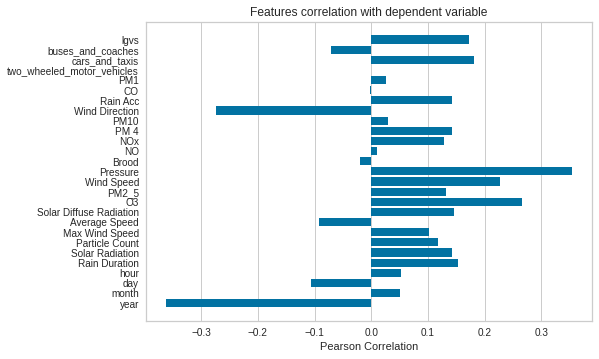

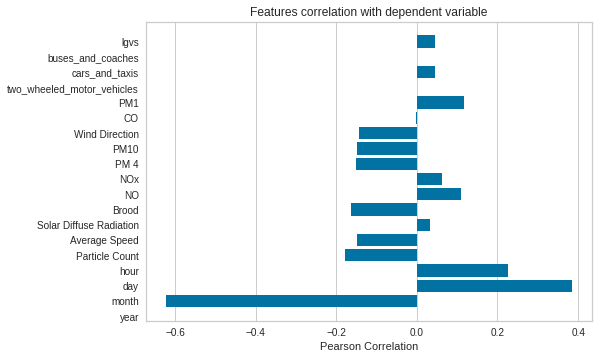

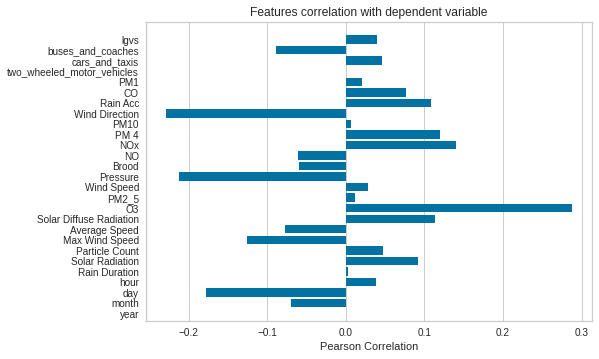

In [175]:
#combined
Ys=DFcom["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

correlation(DFcom.drop('NO2', axis=1),Ys_of_train)

#19
Ys=DF2019["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

correlation(DF2019.drop('NO2', axis=1),Ys_of_train)

#combined
Ys=DF2018["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

correlation(DF2018.drop('NO2', axis=1),Ys_of_train)

# SVM

In [176]:

# for combines 2018 and 2019
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
comSVM = SVC(decision_function_shape='ovo')
comSVM.fit(Xs_of_train, Ys_of_train)



comSVM_train_res = comSVM.predict(Xs_of_train)
#val_res = DT.predict(X_val)
com_acc_train = accuracy_score(comSVM_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {com_acc_train*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')



Training accuracy : 64.30678466076697%


In [177]:

# for 2018 only
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
SVM18 = SVC(decision_function_shape='ovo')
SVM18.fit(Xs_of_train, Ys_of_train)



SVM18_train_res = SVM18.predict(Xs_of_train)
#val_res = DT.predict(X_val)
acc_train_19 = accuracy_score(SVM18_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {acc_train_19*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')



Training accuracy : 61.24893071000855%


In [178]:

# for 2019 only
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
SVM19 = SVC(decision_function_shape='ovo')
SVM19.fit(Xs_of_train, Ys_of_train)



SVM19_train_res = SVM19.predict(Xs_of_train)
#val_res = DT.predict(X_val)
acc_train_19 = accuracy_score(SVM19_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {acc_train_19*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 81.72043010752688%


#Decision tree

In [179]:
#combined 2018 and 2019
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
DTc = DecisionTreeClassifier(max_depth=10, random_state=1234)
DTc.fit(Xs_of_train, Ys_of_train)

DTc_train_res = DTc.predict(Xs_of_train)
#val_res = DT.predict(X_val)
dtacc_trainc = accuracy_score(DTc_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {dtacc_trainc*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 94.91150442477876%


In [180]:
#2018 only
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
DT18 = DecisionTreeClassifier(max_depth=10, random_state=1234)
DT18.fit(Xs_of_train, Ys_of_train)

DT18_train_res = DT18.predict(Xs_of_train)
#val_res = DT.predict(X_val)
dtacc_train18 = accuracy_score(DT18_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {dtacc_train18*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 97.26261762189907%


In [181]:
#2019 only
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
DT19 = DecisionTreeClassifier(max_depth=10, random_state=1234)
DT19.fit(Xs_of_train, Ys_of_train)

DT19_train_res = DT19.predict(Xs_of_train)
#val_res = DT.predict(X_val)
dtacc_train19 = accuracy_score(DT19_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {dtacc_train19*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 100.0%


#Knearest

In [182]:
#combined
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

KNc=KNeighborsClassifier(n_neighbors=5)  
KNc.fit(Xs_of_train, Ys_of_train)

KNc_train_res = KNc.predict(Xs_of_train)
#val_res = DT.predict(X_val)
knacc_trainc = accuracy_score(KNc_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {knacc_trainc*100}%')
#print(f'Validation accuracy: {acc_tsne_val}%')



Training accuracy : 86.65191740412979%


In [183]:
#2018 only
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
KN18 = DecisionTreeClassifier(max_depth=10, random_state=1234)
KN18.fit(Xs_of_train, Ys_of_train)

KN18_train_res = KN18.predict(Xs_of_train)
#val_res = KN.predict(X_val)
knacc_train18 = accuracy_score(KN18_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {knacc_train18*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 97.26261762189907%


In [184]:
#2019 only
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
KN19 = DecisionTreeClassifier(max_depth=10, random_state=1234)
KN19.fit(Xs_of_train, Ys_of_train)

KN19_train_res = KN19.predict(Xs_of_train)
#val_res = KN.predict(X_val)
knacc_train19 = accuracy_score(KN19_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {knacc_train19*100}%')


Training accuracy : 100.0%


#Boosted regression tree

In [185]:
#combined 2018 and 2019
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
BRTc = GradientBoostingClassifier(max_depth=10, random_state=1234)
BRTc.fit(Xs_of_train, Ys_of_train)

BRTc_train_res = BRTc.predict(Xs_of_train)
#val_res = BRT.predict(X_val)
brtacc_trainc = accuracy_score(BRTc_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {brtacc_trainc*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 100.0%


In [186]:
#2018 only
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
BRT18 = GradientBoostingClassifier(max_depth=10, random_state=1234)
BRT18.fit(Xs_of_train, Ys_of_train)

BRT18_train_res = BRT18.predict(Xs_of_train)
#val_res = BRT.predict(X_val)
brtacc_train18 = accuracy_score(BRT18_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {brtacc_train18*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 100.0%


In [187]:
#2019 only
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
BRT19 = GradientBoostingClassifier(max_depth=10, random_state=1234)
BRT19.fit(Xs_of_train, Ys_of_train)

BRT19_train_res = BRT19.predict(Xs_of_train)
#val_res = BRT.predict(X_val)
brtacc_train19 = accuracy_score(BRT19_train_res, Ys_of_train)
#acc_val = acc(val_preds, y_val)
print(f'Training accuracy : {brtacc_train19*100}%')
#print(f'Validation accuracy PCA40: {acc_tsne_val}%')


Training accuracy : 100.0%


#results and graphs of classifiers

#Svm

accuracy : 0.6357388316151202
precision : [0.         0.         0.52882206 0.         0.86885246]
recall: [0.         0.         0.97685185 0.         0.60687023]


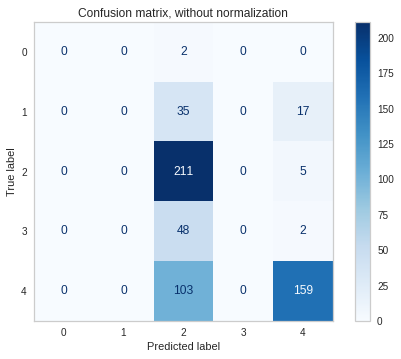

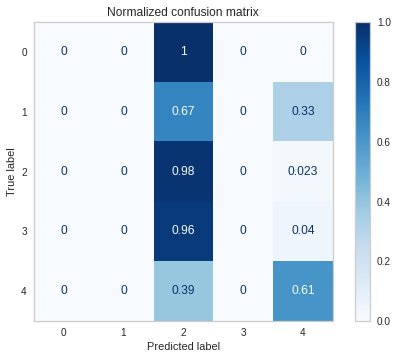

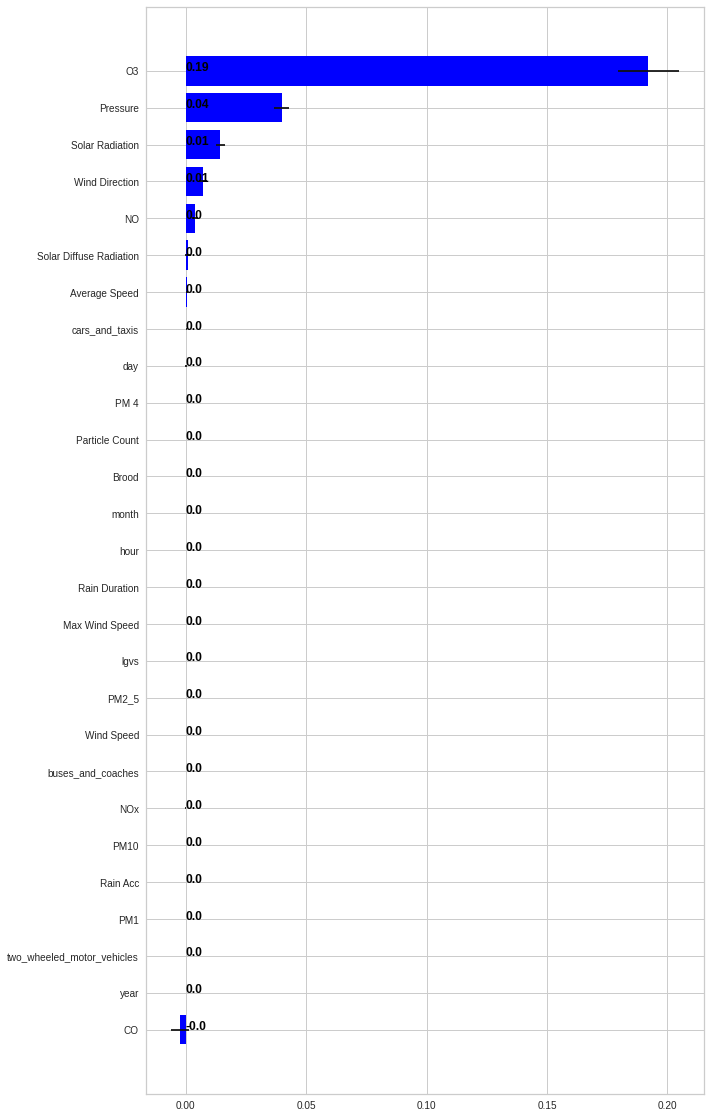

In [188]:
#combined
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testxcom.values
Ys=testycom.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = comSVM.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

svmcom_res=[]
svmcom_res.append(precision_score(y_test, y_pred, average=None))
svmcom_res.append(recall_score(y_test, y_pred, average=None))
svmcom_res.append(f1_score(y_test, y_pred, average=None))
svmcom_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    comSVM, trainxcom, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(comSVM,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainxcom.columns)

accuracy : 0.5896414342629482
precision : [0.         0.         0.4483871  0.         0.81770833]
recall: [0.         0.         0.92666667 0.         0.62055336]


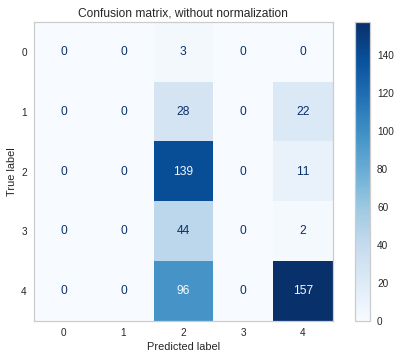

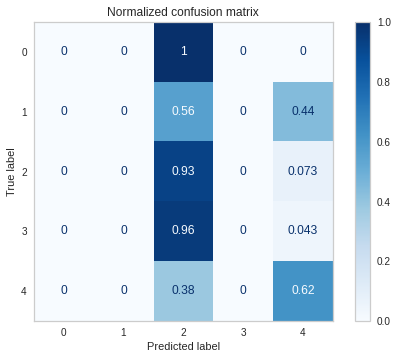

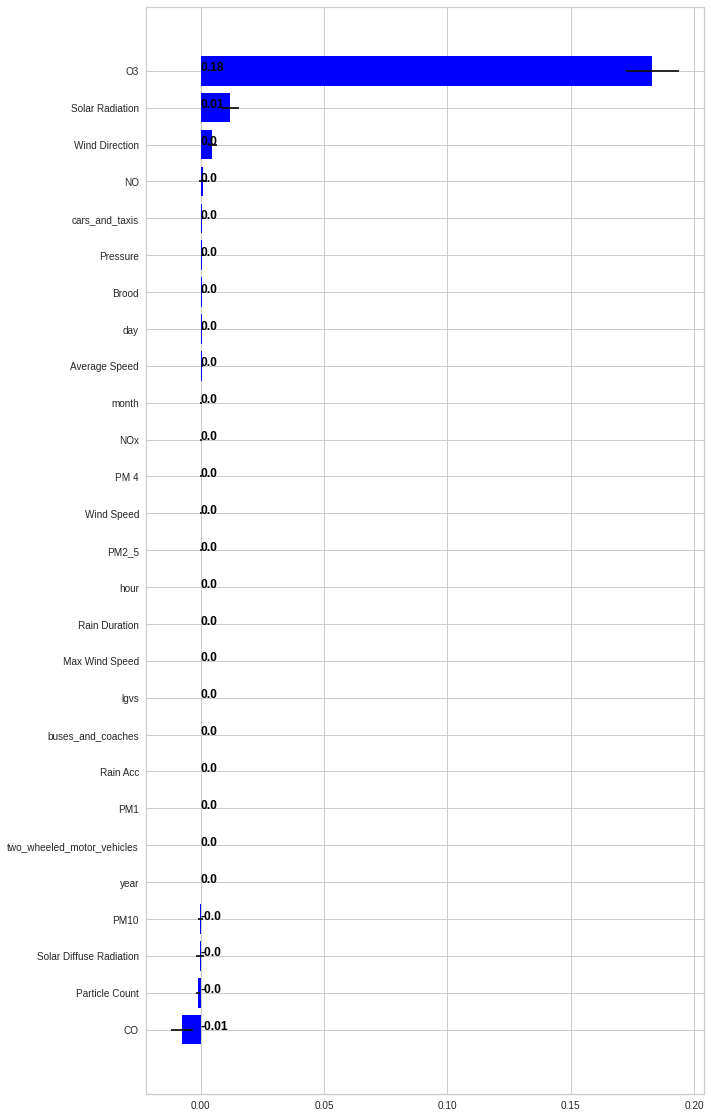

In [189]:
#18
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx18.values
Ys=testy18.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = SVM18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

svm18_res=[]
svm18_res.append(precision_score(y_test, y_pred, average=None))
svm18_res.append(recall_score(y_test, y_pred, average=None))
svm18_res.append(f1_score(y_test, y_pred, average=None))
svm18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    SVM18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(SVM18,Xs_of_test,y_test,class_names)

plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.8148148148148148
precision : [0.         0.         0.81481481]
recall: [0. 0. 1.]


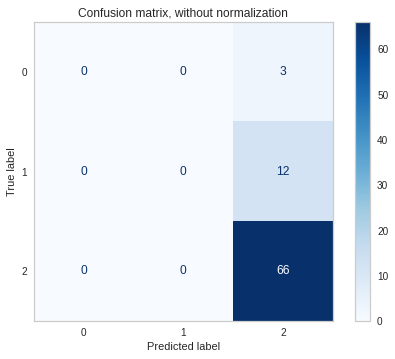

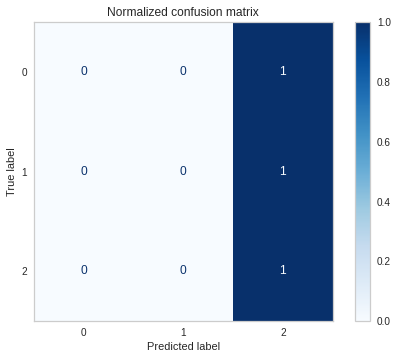

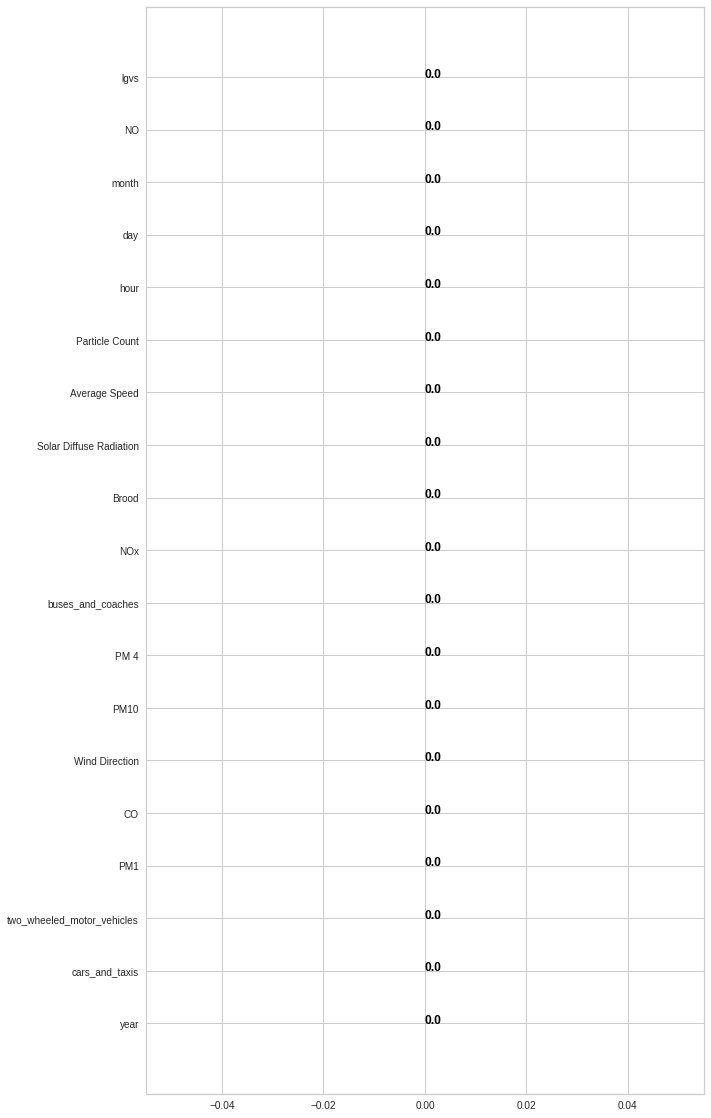

In [190]:
#19
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx19.values
Ys=testy19.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = SVM19.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

svm19_res=[]
svm19_res.append(precision_score(y_test, y_pred, average=None))
svm19_res.append(recall_score(y_test, y_pred, average=None))
svm19_res.append(f1_score(y_test, y_pred, average=None))
svm19_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    SVM19, trainx19, Ys_of_train, n_repeats=15)


class_names=["0","1","2","3","4"]
confplt(SVM19,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx19.columns)

#decision tree

accuracy : 0.8505154639175257
precision : [0.5        0.60714286 0.78861789 0.77419355 0.98367347]
recall: [1.         0.65384615 0.89814815 0.48       0.91984733]


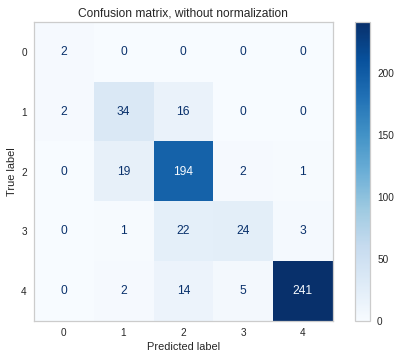

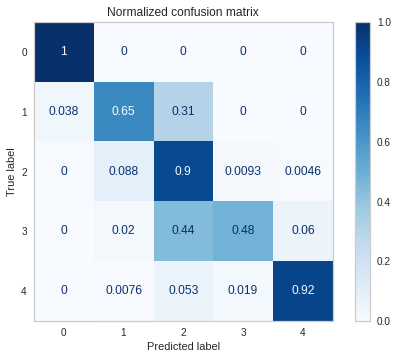

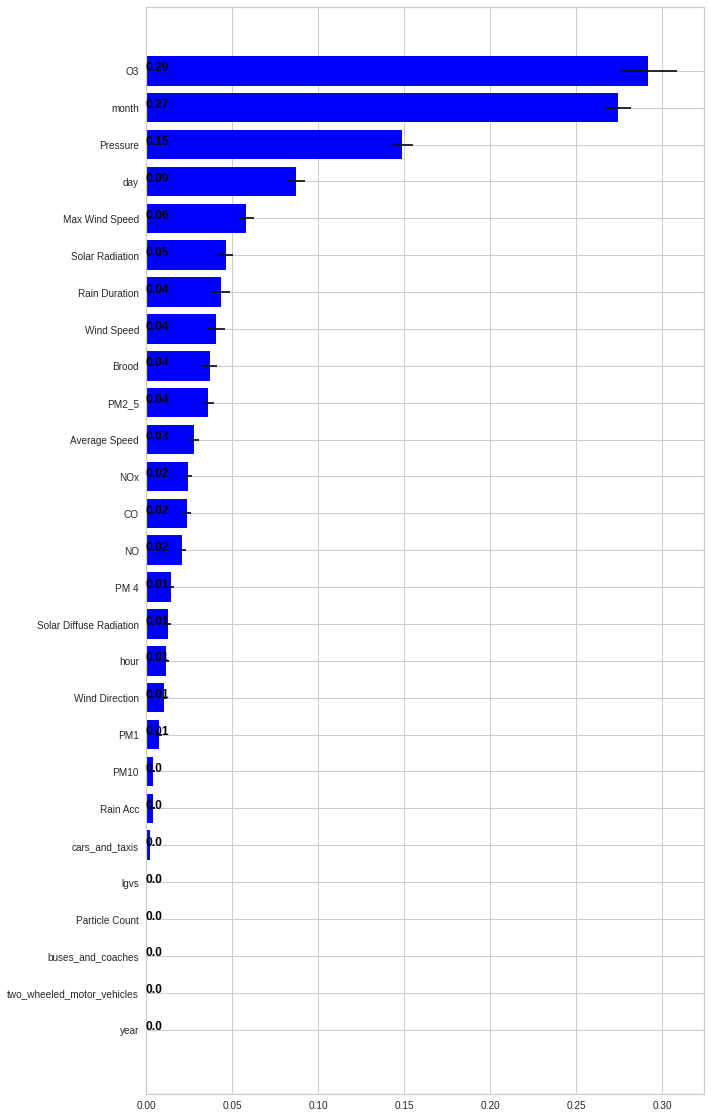

In [191]:
#combined
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testxcom.values
Ys=testycom.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = DTc.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

DTc_res=[]
DTc_res.append(precision_score(y_test, y_pred, average=None))
DTc_res.append(recall_score(y_test, y_pred, average=None))
DTc_res.append(f1_score(y_test, y_pred, average=None))
DTc_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    DTc, trainxcom, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(DTc,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainxcom.columns)

accuracy : 0.852589641434263
precision : [1.         0.73076923 0.77108434 0.64864865 0.96341463]
recall: [0.33333333 0.76       0.85333333 0.52173913 0.93675889]


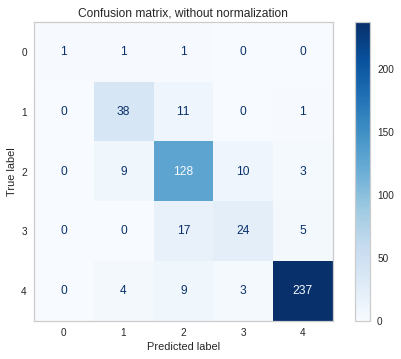

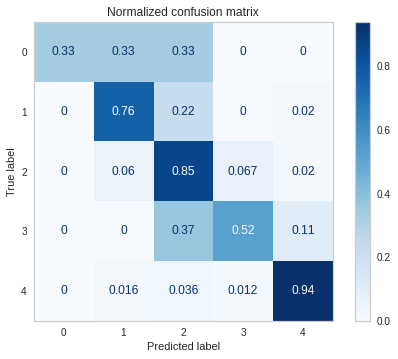

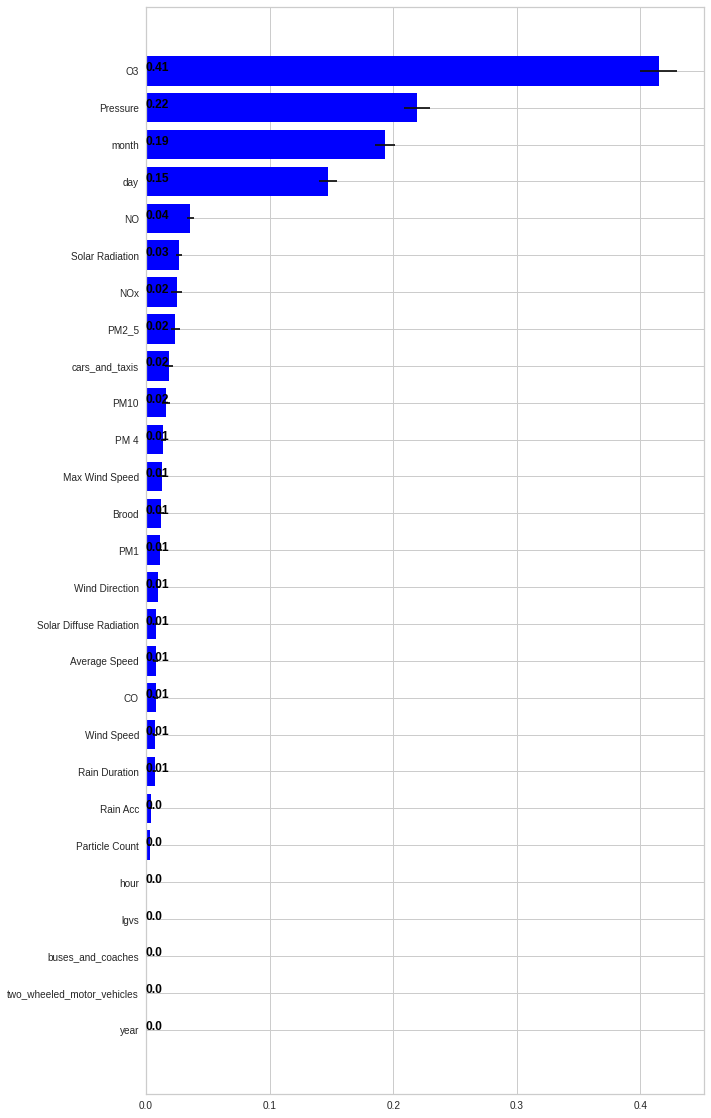

In [192]:
#18
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx18.values
Ys=testy18.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = DT18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

DT18_res=[]
DT18_res.append(precision_score(y_test, y_pred, average=None))
DT18_res.append(recall_score(y_test, y_pred, average=None))
DT18_res.append(f1_score(y_test, y_pred, average=None))
DT18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    DT18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(DT18,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.9012345679012346
precision : [1.         0.7        0.92647059]
recall: [1.         0.58333333 0.95454545]


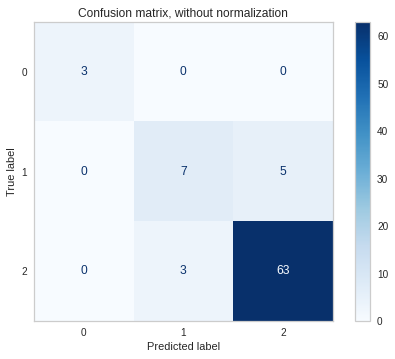

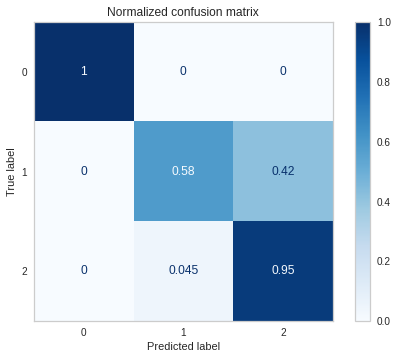

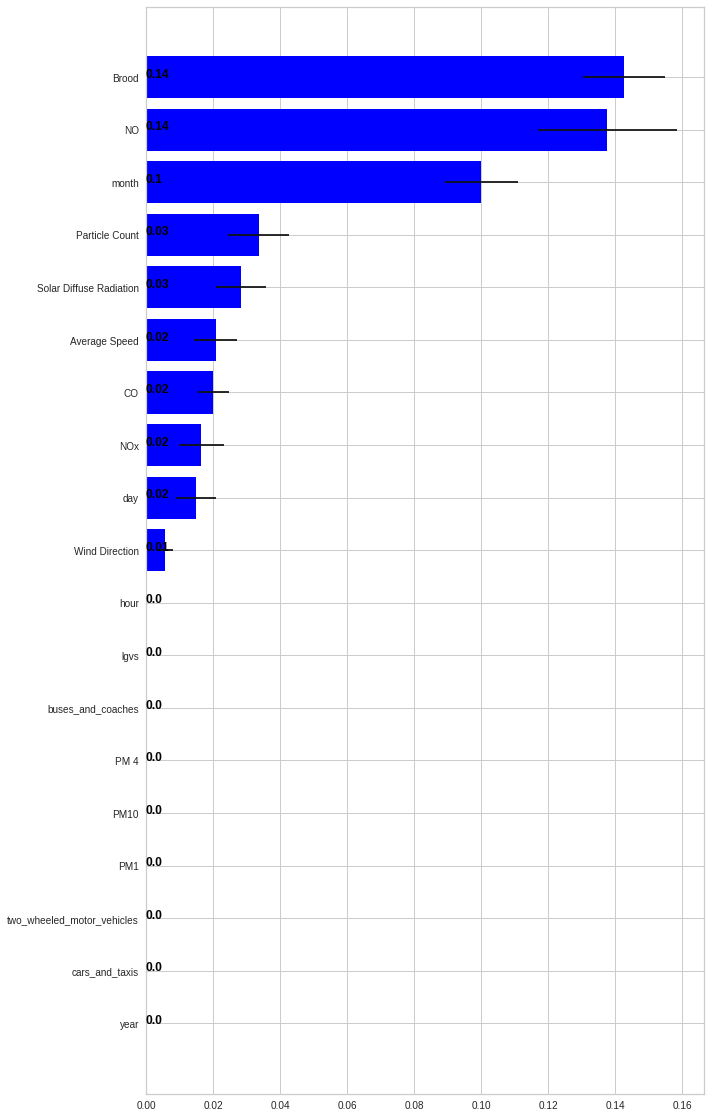

In [193]:
#19
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx19.values
Ys=testy19.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = DT19.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

DT19_res=[]
DT19_res.append(precision_score(y_test, y_pred, average=None))
DT19_res.append(recall_score(y_test, y_pred, average=None))
DT19_res.append(f1_score(y_test, y_pred, average=None))
DT19_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    DT19, trainx19, Ys_of_train, n_repeats=15)


class_names=["0","1","2","3","4"]
confplt(DT19,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx19.columns)

#knear

accuracy : 0.7835051546391752
precision : [0.33333333 0.57446809 0.70342205 0.55172414 0.94583333]
recall: [0.5        0.51923077 0.85648148 0.32       0.86641221]


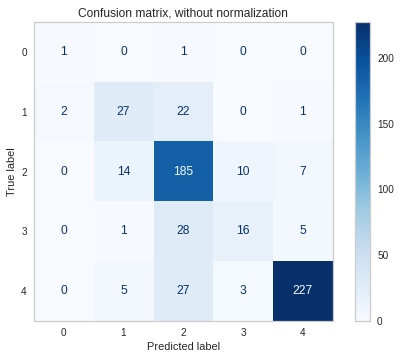

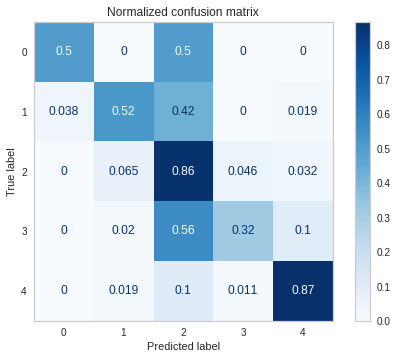

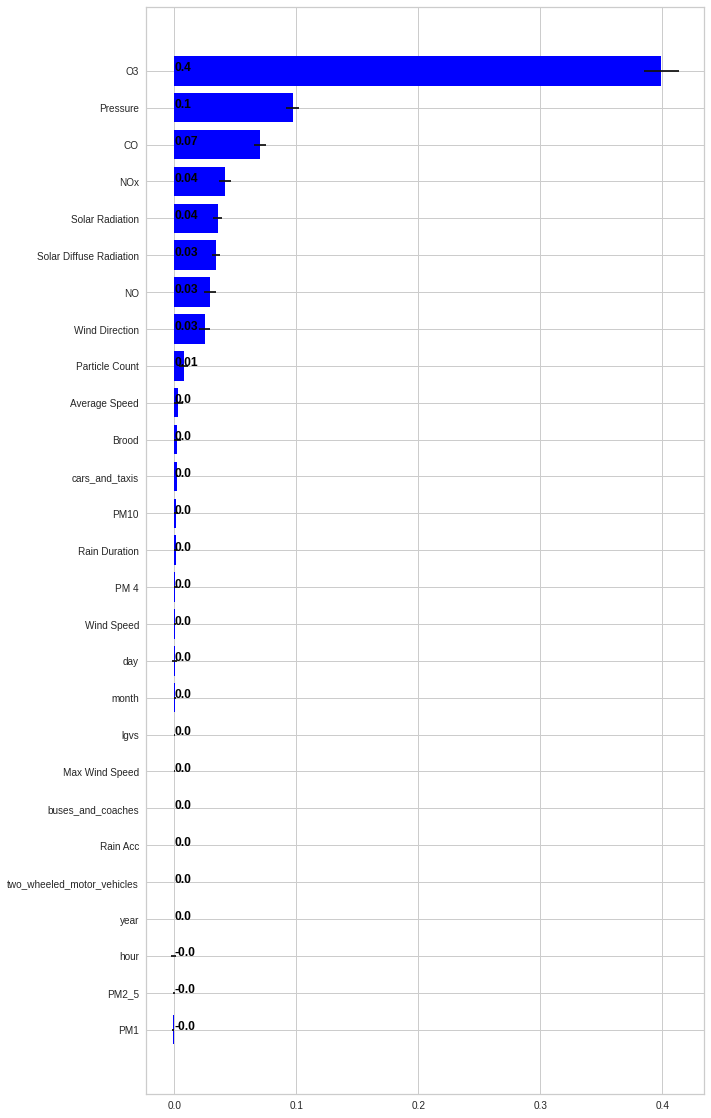

In [194]:
#combined
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testxcom.values
Ys=testycom.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = KNc.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

KNc_res=[]
KNc_res.append(precision_score(y_test, y_pred, average=None))
KNc_res.append(recall_score(y_test, y_pred, average=None))
KNc_res.append(f1_score(y_test, y_pred, average=None))
KNc_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    KNc, trainxcom, Ys_of_train, n_repeats=15)


class_names=["0","1","2","3","4"]
confplt(KNc,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainxcom.columns)

accuracy : 0.852589641434263
precision : [1.         0.73076923 0.77108434 0.64864865 0.96341463]
recall: [0.33333333 0.76       0.85333333 0.52173913 0.93675889]


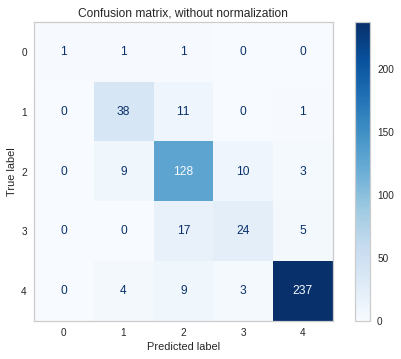

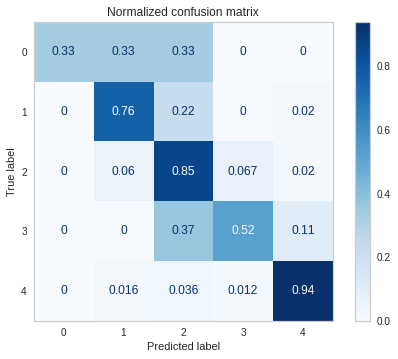

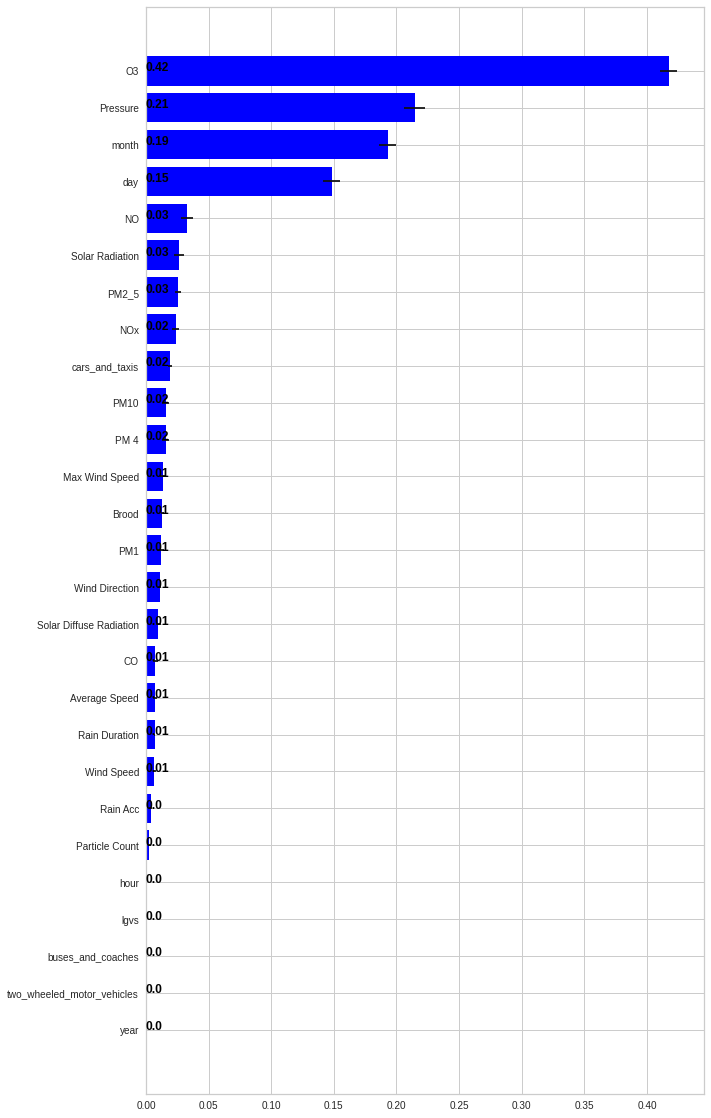

In [195]:
#18
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx18.values
Ys=testy18.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = KN18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

KN18_res=[]
KN18_res.append(precision_score(y_test, y_pred, average=None))
KN18_res.append(recall_score(y_test, y_pred, average=None))
KN18_res.append(f1_score(y_test, y_pred, average=None))
KN18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    KN18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(KN18,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.9012345679012346
precision : [1.         0.7        0.92647059]
recall: [1.         0.58333333 0.95454545]


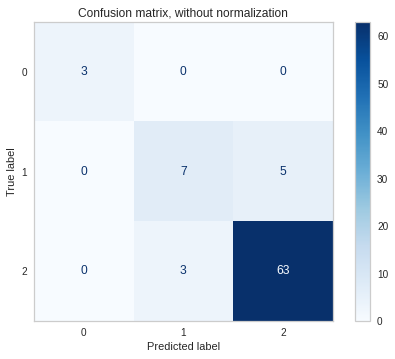

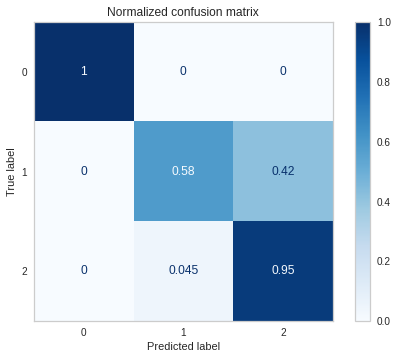

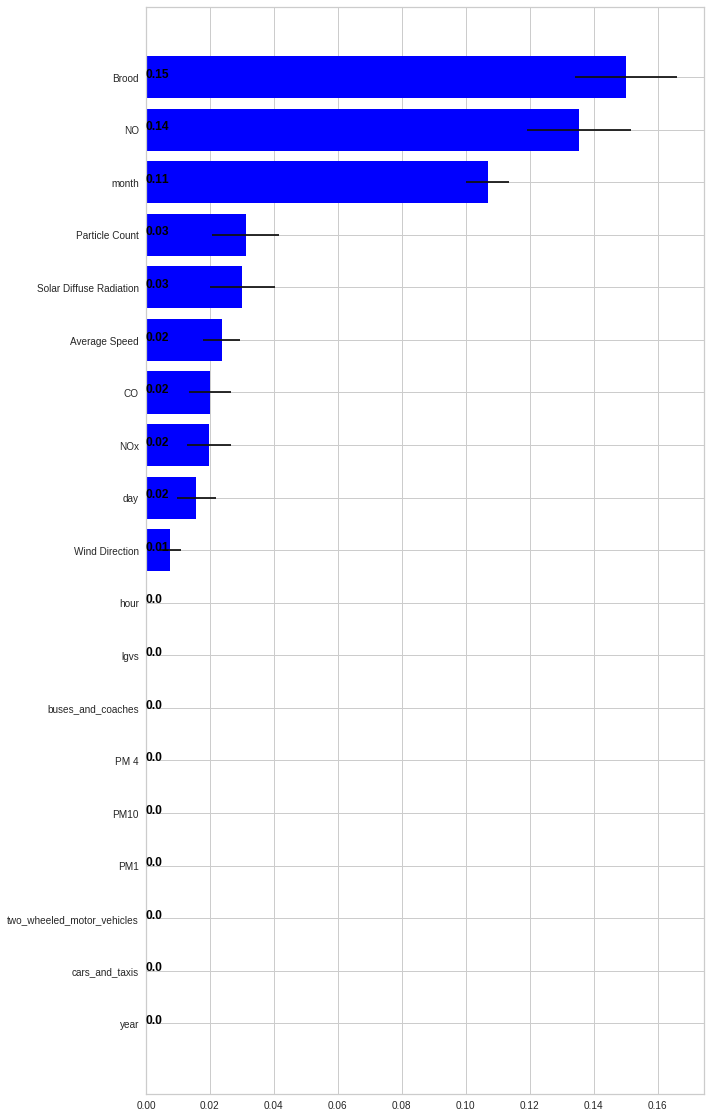

In [196]:
#19
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx19.values
Ys=testy19.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = KN19.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

KN19_res=[]
KN19_res.append(precision_score(y_test, y_pred, average=None))
KN19_res.append(recall_score(y_test, y_pred, average=None))
KN19_res.append(f1_score(y_test, y_pred, average=None))
KN19_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    KN19, trainx19, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(KN19,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx19.columns)

#Boosted regression tree

accuracy : 0.8900343642611683
precision : [1.         0.73076923 0.8583691  0.83333333 0.95471698]
recall: [1.         0.73076923 0.92592593 0.5        0.96564885]


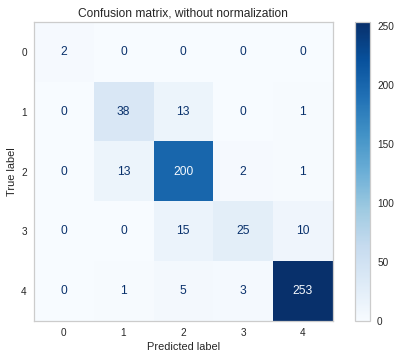

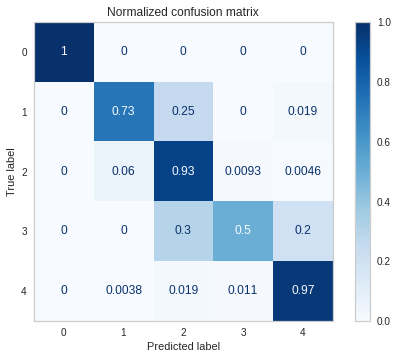

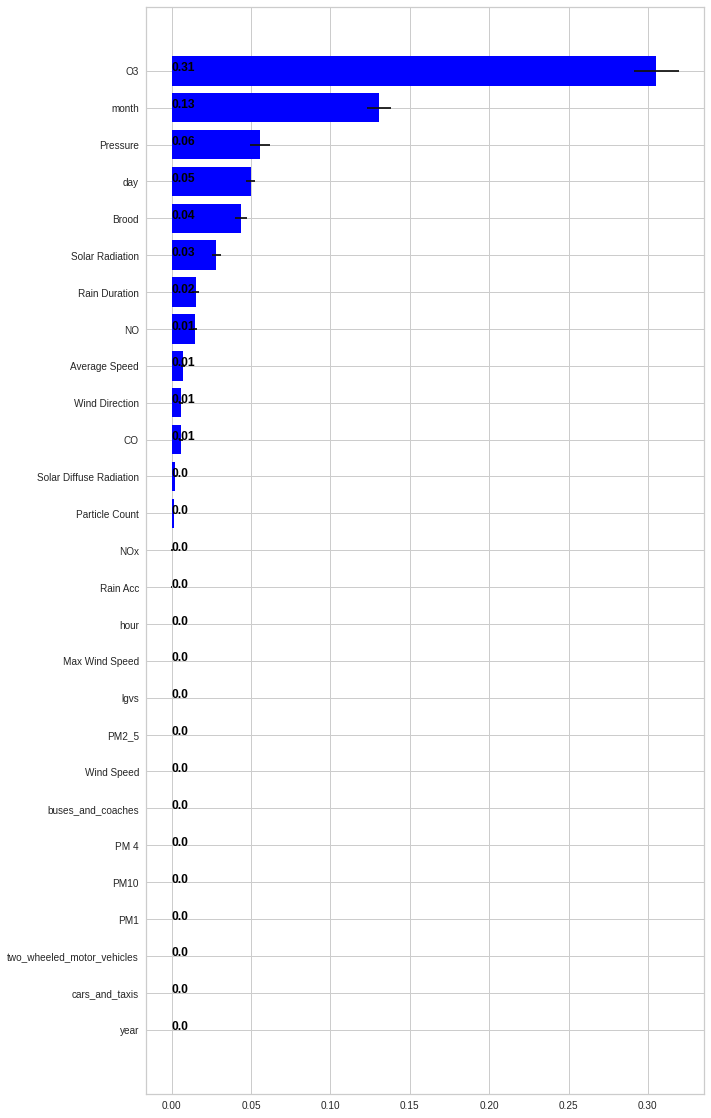

In [197]:
#combined
Xs_of_train=trainxcom.values
Ys=trainycom.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testxcom.values
Ys=testycom.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = BRTc.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

BRTc_res=[]
BRTc_res.append(precision_score(y_test, y_pred, average=None))
BRTc_res.append(recall_score(y_test, y_pred, average=None))
BRTc_res.append(f1_score(y_test, y_pred, average=None))
BRTc_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    BRTc, trainxcom, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(BRTc,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainxcom.columns)

accuracy : 0.8884462151394422
precision : [0.         0.76086957 0.82424242 0.78947368 0.96837945]
recall: [0.         0.7        0.90666667 0.65217391 0.96837945]


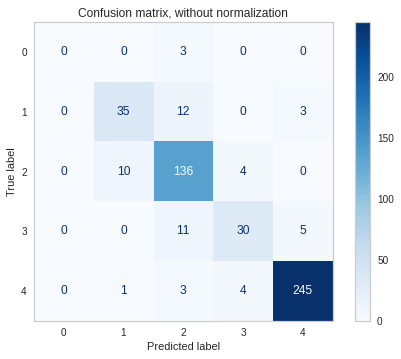

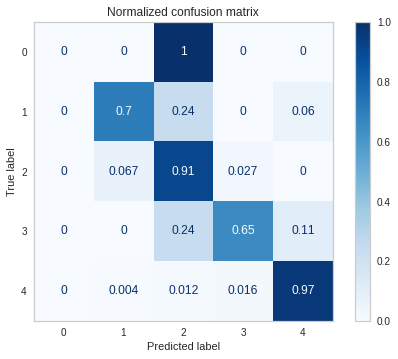

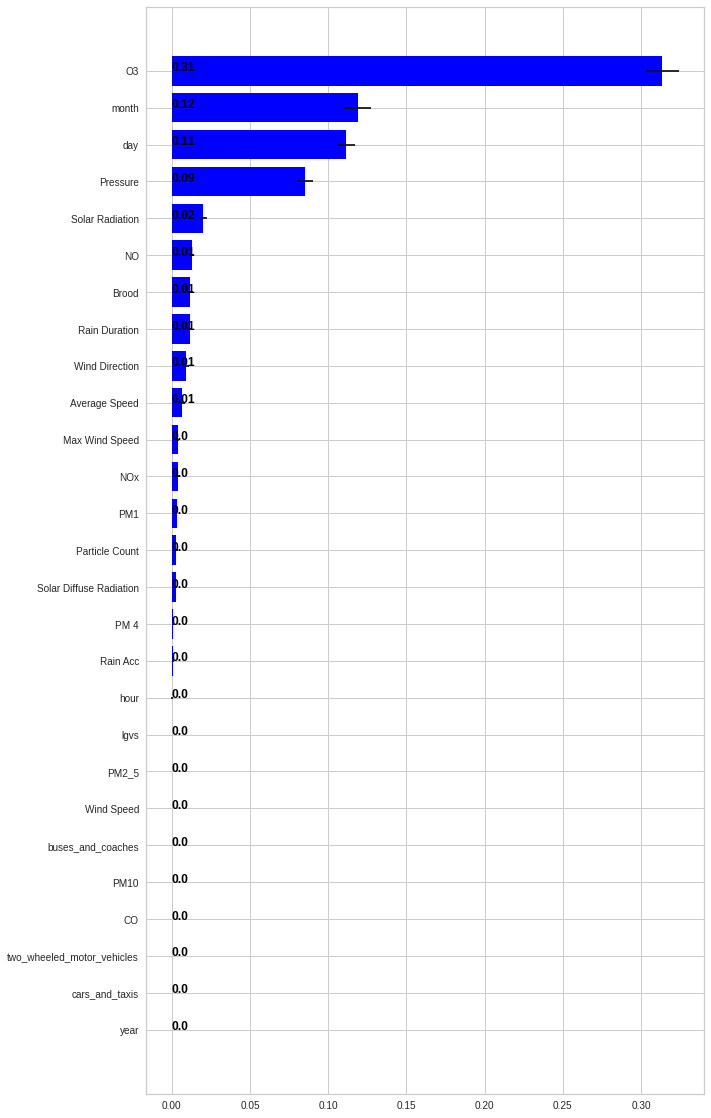

In [198]:
#18
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx18.values
Ys=testy18.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = BRT18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

BRT18_res=[]
BRT18_res.append(precision_score(y_test, y_pred, average=None))
BRT18_res.append(recall_score(y_test, y_pred, average=None))
BRT18_res.append(f1_score(y_test, y_pred, average=None))
BRT18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    BRT18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(BRT18,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.8641975308641975
precision : [1.         0.55555556 0.90140845]
recall: [0.33333333 0.41666667 0.96969697]


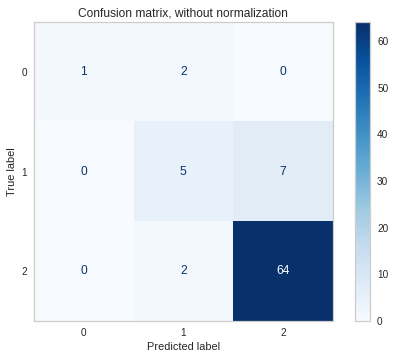

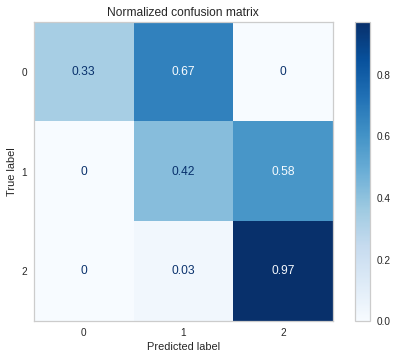

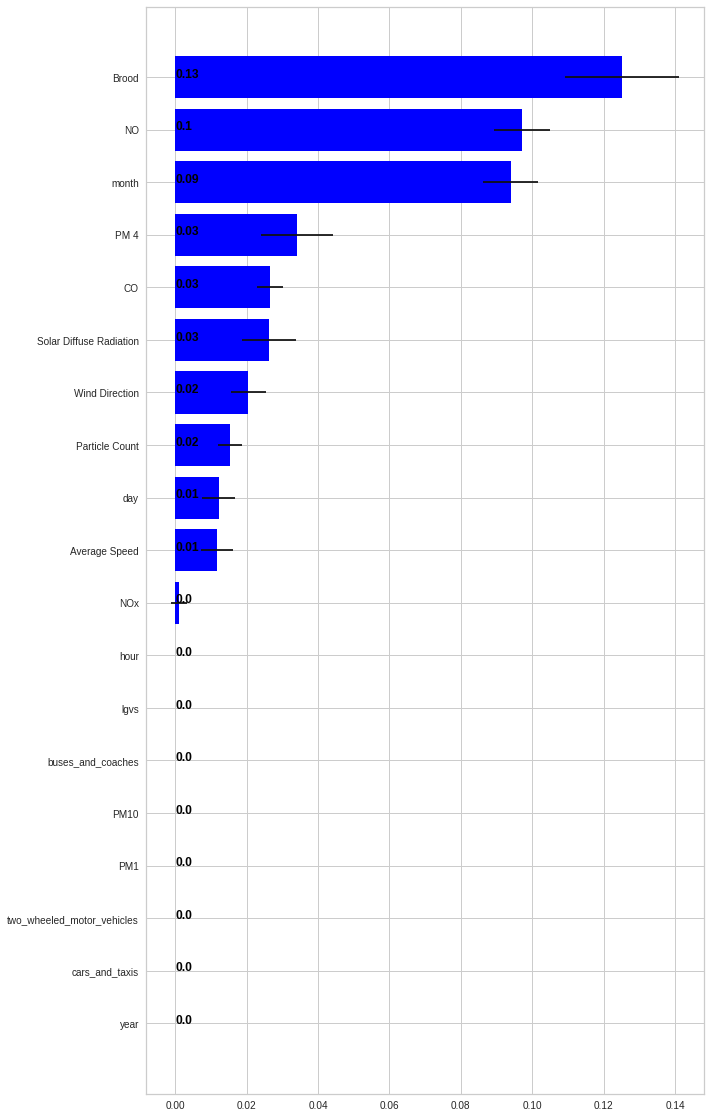

In [199]:
#19
Xs_of_train=trainx19.values
Ys=trainy19.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx19.values
Ys=testy19.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4

y_pred = BRT19.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

BRT19_res=[]
BRT19_res.append(precision_score(y_test, y_pred, average=None))
BRT19_res.append(recall_score(y_test, y_pred, average=None))
BRT19_res.append(f1_score(y_test, y_pred, average=None))
BRT19_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    BRT19, trainx19, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(BRT19,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx19.columns)

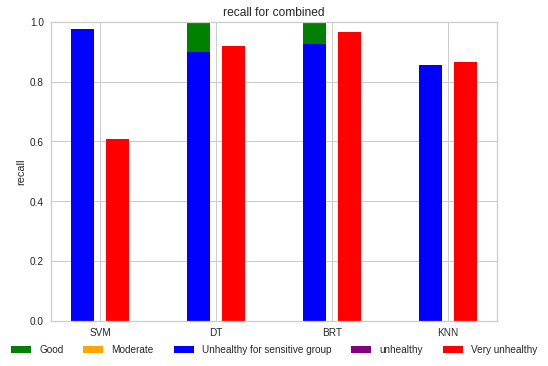

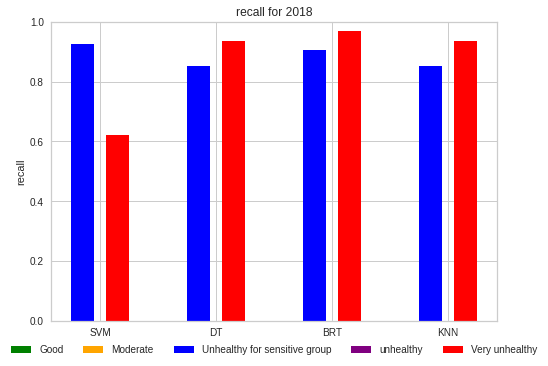

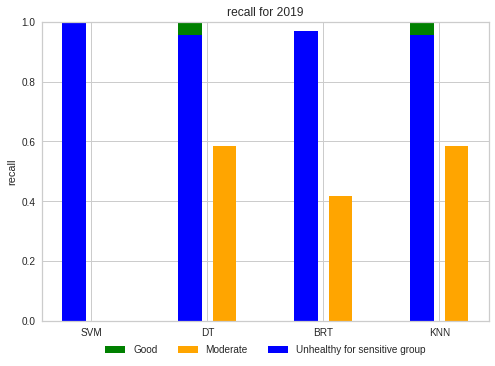

In [200]:
xaxis = [1,2,3,4]
xaxis_dec = [x-0.15 for x in xaxis]
xaxis_inc = [x+0.15 for x in xaxis]
LABELS = ["SVM", "DT", "BRT", 'KNN']

recall_SVM=svmcom_res[1]
recall_DT=DTc_res[1]
recall_BRT=BRTc_res[1]
recall_KNN=KNc_res[1]
rec0 = [recall_SVM[0],recall_DT[0],recall_BRT[0],recall_KNN[0]]
rec1 = [recall_SVM[1],recall_DT[1],recall_BRT[1],recall_KNN[1]]
rec2 = [recall_SVM[2],recall_DT[2],recall_BRT[2],recall_KNN[2]]
rec3 = [recall_SVM[3],recall_DT[3],recall_BRT[3],recall_KNN[3]]
rec4 = [recall_SVM[4],recall_DT[4],recall_BRT[4],recall_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('recall')
plt.title("recall for combined")
plt.show()

recall_SVM=svm18_res[1]
recall_DT=DT18_res[1]
recall_BRT=BRT18_res[1]
recall_KNN=KN18_res[1]
rec0 = [recall_SVM[0],recall_DT[0],recall_BRT[0],recall_KNN[0]]
rec1 = [recall_SVM[1],recall_DT[1],recall_BRT[1],recall_KNN[1]]
rec2 = [recall_SVM[2],recall_DT[2],recall_BRT[2],recall_KNN[2]]
rec3 = [recall_SVM[3],recall_DT[3],recall_BRT[3],recall_KNN[3]]
rec4 = [recall_SVM[4],recall_DT[4],recall_BRT[4],recall_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('recall')

plt.title("recall for 2018")
plt.show()


recall_SVM=svm19_res[1]
recall_DT=DT19_res[1]
recall_BRT=BRT19_res[1]
recall_KNN=KN19_res[1]
rec0 = [recall_SVM[0],recall_DT[0],recall_BRT[0],recall_KNN[0]]
rec1 = [recall_SVM[1],recall_DT[1],recall_BRT[1],recall_KNN[1]]
rec2 = [recall_SVM[2],recall_DT[2],recall_BRT[2],recall_KNN[2]]

ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('recall')
plt.title("recall for 2019")
plt.show()

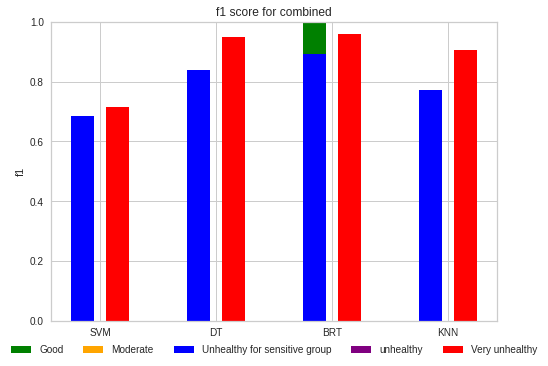

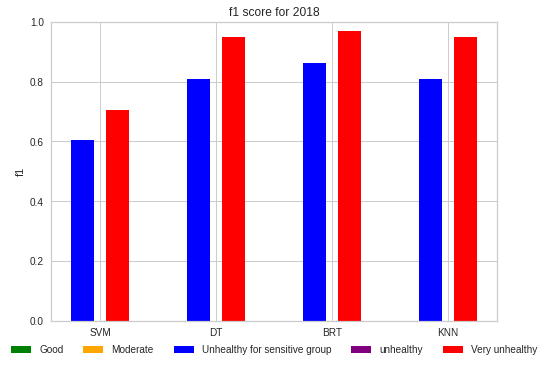

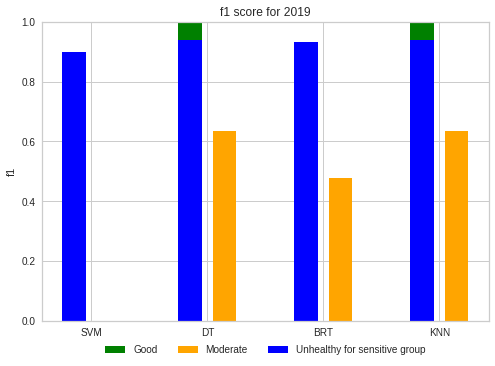

In [201]:
xaxis = [1,2,3,4]
xaxis_dec = [x-0.15 for x in xaxis]
xaxis_inc = [x+0.15 for x in xaxis]
LABELS = ["SVM", "DT", "BRT", 'KNN']

f1_SVM=svmcom_res[2]
f1_DT=DTc_res[2]
f1_BRT=BRTc_res[2]
f1_KNN=KNc_res[2]
rec0 = [f1_SVM[0],f1_DT[0],f1_BRT[0],f1_KNN[0]]
rec1 = [f1_SVM[1],f1_DT[1],f1_BRT[1],f1_KNN[1]]
rec2 = [f1_SVM[2],f1_DT[2],f1_BRT[2],f1_KNN[2]]
rec3 = [f1_SVM[3],f1_DT[3],f1_BRT[3],f1_KNN[3]]
rec4 = [f1_SVM[4],f1_DT[4],f1_BRT[4],f1_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('f1')
plt.title("f1 score for combined")
plt.show()

f1_SVM=svm18_res[2]
f1_DT=DT18_res[2]
f1_BRT=BRT18_res[2]
f1_KNN=KN18_res[2]
rec0 = [f1_SVM[0],f1_DT[0],f1_BRT[0],f1_KNN[0]]
rec1 = [f1_SVM[1],f1_DT[1],f1_BRT[1],f1_KNN[1]]
rec2 = [f1_SVM[2],f1_DT[2],f1_BRT[2],f1_KNN[2]]
rec3 = [f1_SVM[3],f1_DT[3],f1_BRT[3],f1_KNN[3]]
rec4 = [f1_SVM[4],f1_DT[4],f1_BRT[4],f1_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('f1')
plt.title("f1 score for 2018")
plt.show()


f1_SVM=svm19_res[2]
f1_DT=DT19_res[2]
f1_BRT=BRT19_res[2]
f1_KNN=KN19_res[2]
rec0 = [f1_SVM[0],f1_DT[0],f1_BRT[0],f1_KNN[0]]
rec1 = [f1_SVM[1],f1_DT[1],f1_BRT[1],f1_KNN[1]]
rec2 = [f1_SVM[2],f1_DT[2],f1_BRT[2],f1_KNN[2]]

ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('f1')
plt.title("f1 score for 2019")
plt.show()

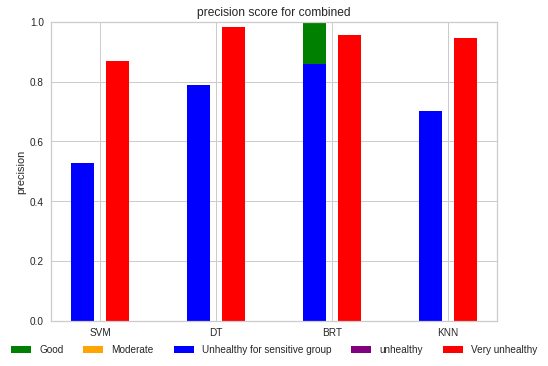

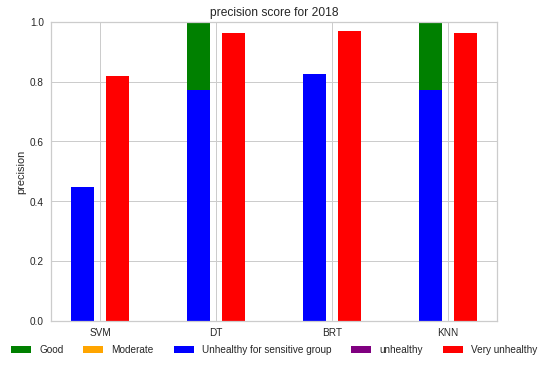

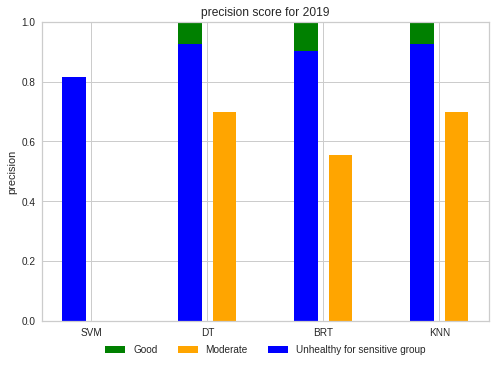

In [202]:
xaxis = [1,2,3,4]
xaxis_dec = [x-0.15 for x in xaxis]
xaxis_inc = [x+0.15 for x in xaxis]
LABELS = ["SVM", "DT", "BRT", 'KNN']

precision_SVM=svmcom_res[0]
precision_DT=DTc_res[0]
precision_BRT=BRTc_res[0]
precision_KNN=KNc_res[0]
rec0 = [precision_SVM[0],precision_DT[0],precision_BRT[0],precision_KNN[0]]
rec1 = [precision_SVM[1],precision_DT[1],precision_BRT[1],precision_KNN[1]]
rec2 = [precision_SVM[2],precision_DT[2],precision_BRT[2],precision_KNN[2]]
rec3 = [precision_SVM[3],precision_DT[3],precision_BRT[3],precision_KNN[3]]
rec4 = [precision_SVM[4],precision_DT[4],precision_BRT[4],precision_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('precision')
plt.title("precision score for combined")
plt.show()

precision_SVM=svm18_res[0]
precision_DT=DT18_res[0]
precision_BRT=BRT18_res[0]
precision_KNN=KN18_res[0]
rec0 = [precision_SVM[0],precision_DT[0],precision_BRT[0],precision_KNN[0]]
rec1 = [precision_SVM[1],precision_DT[1],precision_BRT[1],precision_KNN[1]]
rec2 = [precision_SVM[2],precision_DT[2],precision_BRT[2],precision_KNN[2]]
rec3 = [precision_SVM[3],precision_DT[3],precision_BRT[3],precision_KNN[3]]
rec4 = [precision_SVM[4],precision_DT[4],precision_BRT[4],precision_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('precision')
plt.title("precision score for 2018")
plt.show()


precision_SVM=svm19_res[0]
precision_DT=DT19_res[0]
precision_BRT=BRT19_res[0]
precision_KNN=KN19_res[0]
rec0 = [precision_SVM[0],precision_DT[0],precision_BRT[0],precision_KNN[0]]
rec1 = [precision_SVM[1],precision_DT[1],precision_BRT[1],precision_KNN[1]]
rec2 = [precision_SVM[2],precision_DT[2],precision_BRT[2],precision_KNN[2]]

ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')


ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('precision')
plt.title("precision score for 2019")
plt.show()

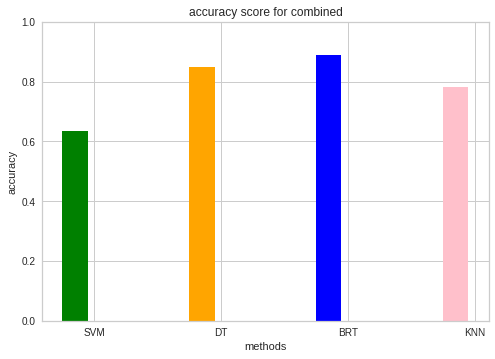

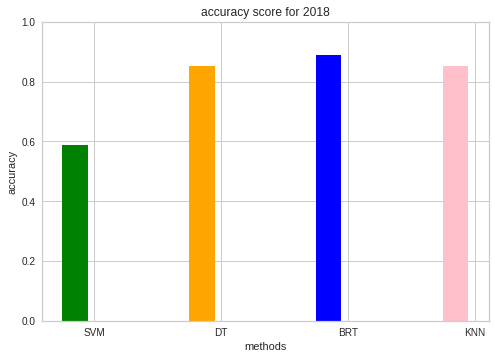

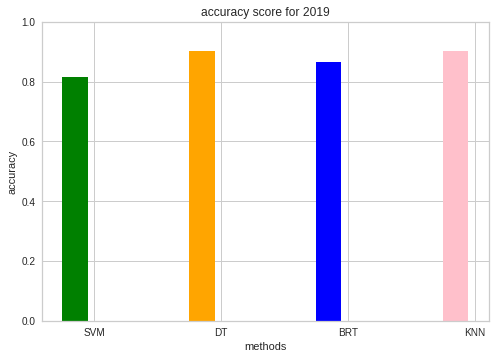

In [203]:
xaxis = [1,2,3,4]
xaxis_dec = [x-0.15 for x in xaxis]
xaxis_inc = [x+0.15 for x in xaxis]
LABELS = ["SVM", "DT", "BRT", 'KNN']

acc_SVM=svmcom_res[3]
acc_DT=DTc_res[3]
acc_BRT=BRTc_res[3]
acc_KNN=KNc_res[3]
rec0 = [acc_SVM,acc_DT,acc_BRT,acc_KNN]


ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color=['green','orange','blue','pink'],align='center')


ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.xlabel('methods')
plt.ylabel('accuracy')
plt.title("accuracy score for combined")
plt.show()

acc_SVM=svm18_res[3]
acc_DT=DT18_res[3]
acc_BRT=BRT18_res[3]
acc_KNN=KN18_res[3]
rec0 = [acc_SVM,acc_DT,acc_BRT,acc_KNN]


ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color=['green','orange','blue','pink'],align='center')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.xlabel('methods')
plt.ylabel('accuracy')
plt.title("accuracy score for 2018")
plt.show()


acc_SVM=svm19_res[3]
acc_DT=DT19_res[3]
acc_BRT=BRT19_res[3]
acc_KNN=KN19_res[3]
rec0 = [acc_SVM,acc_DT,acc_BRT,acc_KNN]

ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color=['green','orange','blue','pink'],align='center', label = 'accuracy')


ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS)
plt.xlabel('methods')
plt.ylabel('accuracy')
plt.title("accuracy score for 2019")
plt.show()